# Short-term Temperature Model Test

## Import dependencies and data

In [159]:
# import dependencies
import os
import json
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model

from scipy.fftpack import fft, ifft, fftfreq

In [160]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'
plot_path = home_path + '\\plotting\\plots\\'
save_path = home_path + '\\model\\saved\\'

In [161]:
# get merged data
data = pd.read_csv(
    data_path + 'data_merged.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3, 4]
)

# convert index.date col to datetime
#data.index = pd.to_datetime(data.index.values)
data.loc[:, ('time', 'date')] = pd.to_datetime(data.time.date)

In [162]:
# define X vars
x_vars = [
    ('flow', 'TA01_GP101'),
    ('state', 'TA01_output'),
    ('state', 'TA02_output'),
    ('temperatures', 'DC_GT101_GM101'),
    ('temperatures', 'DC_GT102_GM102'),
    ('temperatures', 'DC_GT103_GM103'),
    ('temperatures', 'DC_GT104_GM104'),
    ('temperatures', 'DC_GT401_GM401'),
    ('temperatures', 'TA01_GT401_GM401'),
    ('temperatures', 'TA02_GT401_GM401'),
    ('temperatures', 'DC_GT301_damped'),
    ('temperatures', 'DC_GT301_outdoor'),
    ('humidity', 'DC_GT101_GM101'),
    ('humidity', 'DC_GT102_GM102'),
    ('humidity', 'DC_GT103_GM103'),
    ('humidity', 'DC_GT104_GM104'),
    ('humidity', 'DC_GT401_GM401'),
    ('setpoints', 'TA01_GT10X_GM10X'),
    ('sun', 'gsi'),
    ('sun', 'gsi_deriv'),
    ('sun', 'vol'),
    ('sun', 'vol_deriv'),
    ('wind', 'Wx'),
    ('wind', 'Wy'),
    ('time', 'dayofyear'),
    ('time', 'monthofyear'),
    ('time', 'minofday'),
    ('time', 'hourofday')
]

# filter columns to keep only x_vars
data = data[x_vars].copy()

## Describe Df

In [163]:
# print number of NAs
print('Number of NAs\n')
print(data.isna().sum())
print('\n\n')

Number of NAs

category      sensor_ID       
flow          TA01_GP101          13
state         TA01_output         15
              TA02_output         14
temperatures  DC_GT101_GM101      12
              DC_GT102_GM102      12
              DC_GT103_GM103      11
              DC_GT104_GM104      11
              DC_GT401_GM401      13
              TA01_GT401_GM401    13
              TA02_GT401_GM401    12
              DC_GT301_damped     12
              DC_GT301_outdoor    12
humidity      DC_GT101_GM101      12
              DC_GT102_GM102      12
              DC_GT103_GM103      12
              DC_GT104_GM104      10
              DC_GT401_GM401      14
setpoints     TA01_GT10X_GM10X    14
sun           gsi                  2
              gsi_deriv            2
              vol                  2
              vol_deriv            2
wind          Wx                   2
              Wy                   2
time          dayofyear            2
              monthofyear    

In [164]:
# remove single NAN
data = data.dropna(how='any')

In [165]:
# # reduce to one OBS per MIN
data = data.groupby(['month', 'day', 'hour', 'minute'], sort=False).mean()
# dataMean = data.groupby(['month', 'day', 'hour', 'minute'], sort=False).mean()
# dataFirst = data.groupby(['month', 'day', 'hour', 'minute'], sort=False).first()
# dataLast = data.groupby(['month', 'day', 'hour', 'minute'], sort=False).last()

In [166]:
# data = data[data.index.get_level_values(0) != 4]

## Remove pot. erroneous measurements

In [ ]:
data[('flag', 'DC_GT102_GM102_temp')] = (data.temperatures.DC_GT102_GM102 - data.temperatures.DC_GT102_GM102.shift(-2)) > 1
data[('flag', 'DC_GT102_GM102_humid')] = (data.humidity.DC_GT102_GM102 - data.humidity.DC_GT102_GM102.shift(2)) > 10
data[('flag', 'comb')] = data.flag.DC_GT102_GM102_temp & data.flag.DC_GT102_GM102_humid

In [ ]:
hrs = data.groupby(['month', 'day', 'hour']).sum()[('flag', 'comb')] > 0
hrsDrop = hrs[hrs == 1].index.values

In [ ]:
mask = np.array([hrs not in list(hrsDrop) for hrs in data.index.droplevel(-1).values])
data = data[mask]

## GH Temperature & Humidity

### Extract humidity noise w. FFT

In [167]:
# cols = [
#     # ('DC_GT102_GM101'),
#     ('DC_GT102_GM102'), 
#     ('DC_GT103_GM103'), 
#     ('DC_GT104_GM104')
# ]

# for col in cols:
    
#     sig_fft = fft(data.humidity[col].values)
#     sig_fft_filtered = sig_fft.copy()
#     sig_fft_noise = sig_fft.copy()
    
#     #
#     freq = fftfreq(len(data), d=1/5)
#     cut_off = 1/10
    
#     sig_fft_filtered[np.abs(freq) > cut_off] = 0
#     sig_fft_noise[np.abs(freq) <= cut_off] = 0
    
#     # get the filtered signal in time domain
#     filtered = ifft(sig_fft_filtered)
#     noise = ifft(sig_fft_noise)

#     # put in data
# #     data.humidity.loc[:, col + '_noise'] = data.humidity[col]
#     data.loc[:, ('humidity', col + '_filtered')] = filtered.astype('float64')
#     data.loc[:, ('humidity', col + '_noise')] = noise.astype('float64')

## Kalman filtering

In [168]:
cols = [
    (('temperatures', 'DC_GT102_GM102'), 3),
    (('temperatures', 'DC_GT103_GM103'), 3),
    (('temperatures', 'DC_GT104_GM104'), 3),
    (('temperatures', 'DC_GT401_GM401'), 3),
    (('temperatures', 'TA01_GT401_GM401'), 3),
    (('temperatures', 'DC_GT301_outdoor'), 3),
    (('temperatures', 'DC_GT301_damped'), 3),
    (('humidity', 'DC_GT102_GM102'), 3),
    (('humidity', 'DC_GT103_GM103'), 3),
    (('humidity', 'DC_GT104_GM104'), 3),
    
]

for colSpec in cols:
    for day in data.groupby(['month', 'day']).count().index.values:
        # apply KALMAN filter to measurements
        col = colSpec[0]
        varExp = colSpec[-1]

        # get data
        X = data.loc[day, col].values
        n = len(X)

        # process variance, measurement variance
        Q = 1e-5
        R = 0.1**varExp

        xhat=np.zeros(n)      # a posteri estimate of x
        P=np.zeros(n)         # a posteri error estimate
        xhatminus=np.zeros(n) # a priori estimate of x
        Pminus=np.zeros(n)    # a priori error estimate
        K=np.zeros(n)         # gain or blending factor

        # intial guesses
        xhat[0] = X[0]
        P[0] = 1

        for k in range(1,n):
            # time update
            xhatminus[k] = xhat[k-1]
            Pminus[k] = P[k-1]+Q

            # measurement update
            K[k] = Pminus[k]/( Pminus[k]+R )
            xhat[k] = xhatminus[k]+K[k]*(X[k]-xhatminus[k])
            P[k] = (1-K[k])*Pminus[k]

        data.loc[day, col] = xhat

C:\Users\Oskar\AppData\Local\Temp\ipykernel_17028\164041995.py:22: PerformanceWarning: indexing past lexsort depth may impact performance.
  X = data.loc[day, col].values
C:\Users\Oskar\AppData\Local\Temp\ipykernel_17028\164041995.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  data.loc[day, col] = xhat


In [169]:
### create "better" estimate of temperature var, w. proper avg.
data[('temperatures', 'TA01_GT10X_GM10X')] = data.temperatures[[
    # ('DC_GT102_GM101'),
    ('DC_GT102_GM102'), 
    ('DC_GT103_GM103'), 
    ('DC_GT104_GM104')
]].values.mean(axis=1)

In [170]:
### create "better" estimate of temperature var, w. proper avg.
data[('humidity', 'TA01_GT10X_GM10X')] = data.humidity[[
    # ('DC_GT102_GM101'),
    ('DC_GT102_GM102'), 
    ('DC_GT103_GM103'), 
    ('DC_GT104_GM104')
]].values.mean(axis=1)

In [171]:
# ### create "better" estimate of temperature var, w. proper avg.
# data[('humidity', 'TA01_GT10X_GM10X_filtered')] = data.humidity[[
#     # ('DC_GT102_GM101_filtered'),
#     ('DC_GT102_GM102_filtered'), 
#     ('DC_GT103_GM103_filtered'), 
#     ('DC_GT104_GM104_filtered')
# ]].values.mean(axis=1)

In [172]:
# ### create "better" estimate of temperature var, w. proper avg.
# data[('humidity', 'TA01_GT10X_GM10X_noise')] = data.humidity[[
#     # ('DC_GT102_GM101_noise'),
#     ('DC_GT102_GM102_noise'), 
#     ('DC_GT103_GM103_noise'), 
#     ('DC_GT104_GM104_noise')
# ]].values.mean(axis=1)

## Split into training / testing

In [173]:
# filter data by variables
model_vars = [
    ('state', 'TA01_output'),
    ('state', 'TA02_output'),
#     ('flow', 'TA01_GP101'),
#     ('flow', 'TA02_GP101'),
    ('temperatures', 'TA01_GT10X_GM10X'),
#     ('temperatures', 'DC_GT102_GM102'),
#     ('temperatures', 'DC_GT103_GM103'),
#     ('temperatures', 'DC_GT104_GM104'),
    ('temperatures', 'DC_GT401_GM401'),
    ('temperatures', 'TA01_GT401_GM401'),
    ('temperatures', 'DC_GT301_damped'),
#     ('temperatures', 'DC_GT301_outdoor'),
#     ('humidity', 'DC_GT102_GM102'),
#     ('humidity', 'DC_GT103_GM103'),
#     ('humidity', 'DC_GT104_GM104'),
    ('humidity', 'TA01_GT10X_GM10X'),
#     ('humidity', 'DC_GT102_GM102_filtered'),
#     ('humidity', 'DC_GT103_GM103_filtered'),
#     ('humidity', 'DC_GT104_GM104_filtered'),
#     ('humidity', 'TA01_GT10X_GM10X_filtered'),
#     ('humidity', 'DC_GT102_GM102_noise'),
#     ('humidity', 'DC_GT103_GM103_noise'),
#     ('humidity', 'DC_GT104_GM104_noise'),
#     ('humidity', 'TA01_GT10X_GM10X_noise'),
    ('sun', 'gsi'),
    ('sun', 'gsi_deriv'),
    ('time', 'minofday'),
]

data = data[model_vars].copy()

In [174]:
## Randomly select days for trainin and testing
days = data.groupby(['month', 'day']).count().index.values

# get number of days f. testing / training
train_frac = 0.9
train_n = int(len(days) * train_frac)
test_n = len(days) - train_n

# split dataset
np.random.shuffle(days)
mask = np.array([day in list(days[:train_n]) for day in data.index.droplevel(-1).droplevel(-1).values])
data_train = data.loc[mask].copy()
data_test = data.loc[~mask].copy()

# del data

## Normalize w. training data

In [175]:
col_params = {}
for col in data_train.columns:
# for col in data_train.columns:
    cat, var = col
    
    if cat == 'temperatures' and (var in ['DC_GT102_GM102', 'DC_GT103_GM103', 'DC_GT104_GM104', 'TA01_GT10X_GM10X']):
        continue
    
    mean = data_train[col].mean()
    std = data_train[col].std()
    max_val = data_train[col].max()
    min_val = data_train[col].min()
    
#     data_train[col] = (data_train[col] - mean) / std
#     data_test[col] = (data_test[col] - mean) / std    
    
#     # make positive
    data_train[col] = data_train[col] + abs(min(0, min_val))
    data_train[col] = (data_train[col] - min_val) / (max_val - min_val)
    
    data_test[col] = data_test[col] + abs(min(0, min_val))
    data_test[col] = (data_test[col] - min_val) / (max_val - min_val)
    data_test[col] = data_test[col].apply(lambda val: max(min(val, 1.0), 0.0))
    
    col_params[col] = {
        'mean':mean,
        'std':std,
        'max':max_val,
        'min':min_val
    }

## Save data info

In [176]:
# days = {
#     'training':days[:train_n],
#     'testing':days[train_n:]
# }

In [177]:
# json_path = home_path + '\\misc\\data_split.json'
# json_obj = json.dumps(days)
# with open(json_path, 'w', encoding='utf-8') as f:
#     json.dump(json_obj, f, ensure_ascii=False, indent=4)

In [178]:
# json DUMP params....

## Data preparation

In [179]:
t_steps = 10   # 10-min predictions
n_steps = 30   # 20-min backwards look

train_frac = 0.9

In [180]:
targets_train = pd.concat([data_train.pop(col) for col in [
#     ('temperatures', 'DC_GT102_GM102'),
#     ('temperatures', 'DC_GT103_GM103'),
#     ('temperatures', 'DC_GT104_GM104'),
    ('temperatures', 'TA01_GT10X_GM10X'),
]], axis=1)
targets_train = (targets_train - targets_train.shift(t_steps)) * 10

targets_test = pd.concat([data_test.pop(col) for col in [
#     ('temperatures', 'DC_GT102_GM102'),
#     ('temperatures', 'DC_GT103_GM103'),
#     ('temperatures', 'DC_GT104_GM104'),
    ('temperatures', 'TA01_GT10X_GM10X'),
]], axis=1)
targets_test = (targets_test - targets_test.shift(t_steps)) * 10

### Create sequences

In [181]:
def date_flagger(data, n_steps):
    # get flagged datesvalues
#     data['minute'] = data.index.get_level_values(3).values    
#     data['date_flag'] = data.minute - data.minute.shift(n_steps) != (n_steps)

    data['hour'] = data.index.get_level_values(2).values    
    data['date_flag'] = data.hour - data.hour.shift(n_steps) > 1
    
    # get positions in data, w.r.t. n_step removed observations at start
    flagged_idx = np.where(data.date_flag.values == 1)
    flagged_idx = flagged_idx[0] - n_steps
    
    del data['hour'], data['date_flag']
    
    return flagged_idx

In [182]:
def seq_maker(data, targets, n_steps):
    
    vals = data.values
    sequences = []
    for i in range(len(vals) - n_steps):
        sequences.append(vals[i:i+n_steps])
    sequences = np.stack(sequences)
    
    flags = date_flagger(data, n_steps)
    mask = [idx not in flags for idx in range(len(sequences))]
    
    sequences = sequences[mask]
    targets = targets[n_steps:][mask]
    
    return sequences, targets

In [183]:
# make sequences
sequences_train, targets_train = seq_maker(data_train, targets_train, n_steps)
sequences_test, targets_test = seq_maker(data_test, targets_test, n_steps)

In [184]:
targets_train = targets_train.values
targets_test = targets_test.values

### Set test sequences constant for t:t+t_steps (except TA01, TA02)

In [185]:
# set all subsequent values equal to observed value at t, except f. FLOWS
sequences_test[:, -t_steps:, 2:] = sequences_test[:, -t_steps:-(t_steps-1), 2:]

## Define LSTM Regressor

In [186]:
tf.keras.backend.clear_session()

In [187]:
layerList = [
    layers.Input(shape=(
        sequences_train.shape[1],
        sequences_train.shape[2]
    )),
    layers.Bidirectional(layers.LSTM(
        units=64,
#         units=32,
        return_sequences=False,
        activation='tanh',
        recurrent_activation='sigmoid',
        activity_regularizer='l2',
        recurrent_dropout=0.2,
        kernel_initializer=tf.keras.initializers.GlorotNormal()
    )),
    layers.BatchNormalization(),
#     layers.LSTM(
#         units=32,
# #         units=32,
#         return_sequences=False,
#         activation='tanh',
#         recurrent_activation='sigmoid',
#         activity_regularizer='l2',
#         recurrent_dropout=0.5,
#         kernel_initializer=tf.keras.initializers.GlorotNormal()
#     ),
#     layers.BatchNormalization(),
#     layers.LSTM(
#         units=16,
# #         units=32,
#         return_sequences=False,
#         activation='tanh',
#         recurrent_activation='sigmoid',
#         activity_regularizer='l2',
#         recurrent_dropout=0.5,
#         kernel_initializer=tf.keras.initializers.GlorotNormal()
#     ),
#     layers.BatchNormalization(),
    layers.Dense(
        units=1,
        activation=None,
        activity_regularizer='l2'
    )
]

In [188]:
# layerList = [
#     layers.Input(shape=(
#         sequences_train.shape[1],
#         sequences_train.shape[2]
#     )),
#     layers.LSTM(
#         units=64,
#         return_sequences=True,
#         activation='tanh',
#         recurrent_activation='sigmoid',
#         activity_regularizer='l2',
#         recurrent_dropout=0.2,
#         kernel_initializer=tf.keras.initializers.GlorotNormal()
#     ),
#     layers.BatchNormalization(),
#     layers.LSTM(
#         units=64,
#         return_sequences=True,
#         activation='tanh',
#         recurrent_activation='sigmoid',
#         activity_regularizer='l2',
#         recurrent_dropout=0.5,
#         kernel_initializer=tf.keras.initializers.GlorotNormal()
#     ),
#     layers.BatchNormalization(),
#     layers.LSTM(
#         units=32,
#         return_sequences=False,
#         activation='tanh',
#         recurrent_activation='sigmoid',
#         activity_regularizer='l2',
#         recurrent_dropout=0.5,
#         kernel_initializer=tf.keras.initializers.GlorotNormal()
#     ),
#     layers.BatchNormalization(),
#     layers.Dense(
#         units=1,
#         activation=None,
#         activity_regularizer='l2'
#     )
# ]

In [189]:
lr = 0.01
model = tf.keras.models.Sequential(layers=layerList, name='model')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss="mse")
# model.compile(optimizer=tf.keras.optimizers.experimental.RMSprop(learning_rate=lr))
# model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.95, nesterov=True), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 128)              37888     
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 38,529
Trainable params: 38,273
Non-trainable params: 256
_________________________________________________________________


In [190]:
# model2 = tf.keras.models.load_model(save_path + 'temp_diff_model_v320')
# model2.summary()

In [191]:
# # copy weigths from pre-trained
# for idx, layer in enumerate(model.layers):
#     layer.set_weights(model2.layers[idx].get_weights())

In [192]:
trainHist = model.fit(
    sequences_train,
    targets_train,
    epochs=20,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3, mode="min"),
#         tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode="min"),
#         tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr * (0.9 ** epoch))
    ],
)

Epoch 1/20
1090/1090 [==============================] - 63s 54ms/step - loss: 5.8816 - val_loss: 19.1863
Epoch 2/20
1090/1090 [==============================] - 67s 62ms/step - loss: 3.4368 - val_loss: 11.4833
Epoch 3/20
1090/1090 [==============================] - 67s 62ms/step - loss: 2.8750 - val_loss: 14.6596
Epoch 4/20
1090/1090 [==============================] - 65s 59ms/step - loss: 2.5858 - val_loss: 14.7190
Epoch 5/20
1090/1090 [==============================] - 66s 60ms/step - loss: 2.4256 - val_loss: 16.3309
Epoch 6/20
1090/1090 [==============================] - 66s 60ms/step - loss: 2.2359 - val_loss: 17.7467
Epoch 7/20
1090/1090 [==============================] - 67s 62ms/step - loss: 2.1300 - val_loss: 17.5569
Epoch 8/20
1090/1090 [==============================] - 65s 60ms/step - loss: 2.0262 - val_loss: 15.9160
Epoch 9/20
1090/1090 [==============================] - 68s 62ms/step - loss: 1.9511 - val_loss: 14.2298
Epoch 10/20
  86/1090 [=>............................] 

KeyboardInterrupt: 

In [ ]:
# model_name = 'temp_diff_model_v330'
# model.save(save_path + model_name)

In [87]:
model2 = tf.keras.models.load_model(save_path + 'temp_diff_model_v320')
# # model2.summary()

In [193]:
preds = model.predict(sequences_test)

571/571 [==============================] - 6s 10ms/step


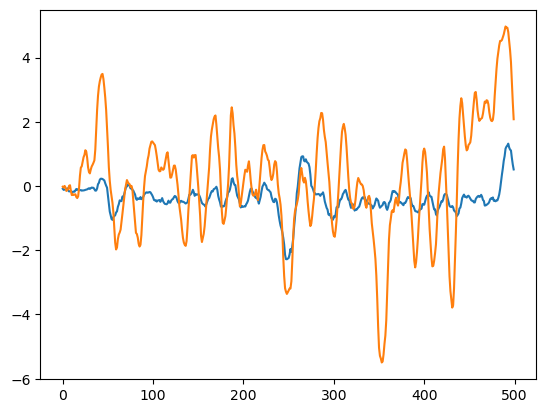

In [194]:
plt.plot(np.squeeze(preds)[:500])
plt.plot(targets_test[:500])
plt.show()

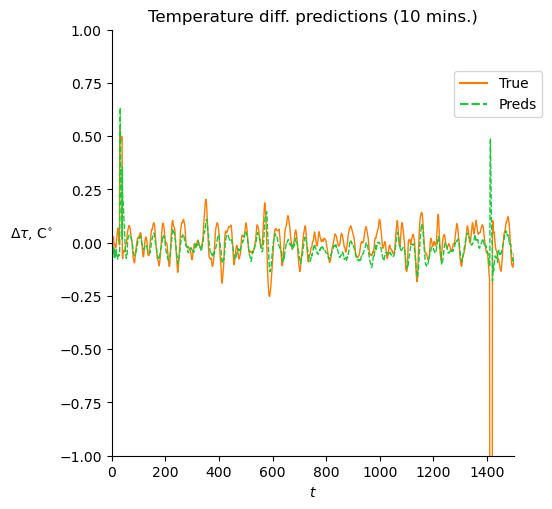

In [107]:
preds_df = pd.DataFrame(data=[np.squeeze(targets_test) / 10, np.squeeze(preds) / 10]).T
preds_df.columns = ['True', 'Preds']

ax = sns.relplot(
    data=preds_df,
    kind='line',
    palette=sns.color_palette('bright')[1:3],
    linewidth=1.0,
    markers=False,
    dashes=True
)

# ax.set_xticklabels(step=2)
sns.move_legend(ax, loc='upper right', frameon=True, bbox_to_anchor=(0.9, 0.9))
plt.xlim(0, 1500)
plt.ylim(-1.0, 1.0)
plt.xlabel('$t$')
plt.ylabel('$\Delta \\tau$, C$^{\circ}$', rotation=0, labelpad=20)
plt.title('Temperature diff. predictions (10 mins.)')
plt.savefig(plot_path + 'temp_diff_model_preds.png', bbox_inches='tight', dpi=200)
plt.show()

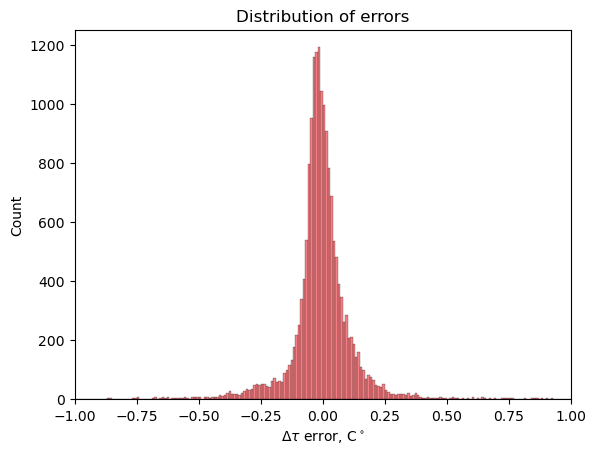

In [109]:
# temp_diffs = np.abs(np.squeeze(preds / 10) - targets_test / 10)
temp_diffs = (np.squeeze(preds) / 10) - (np.squeeze(targets_test) / 10)
# temp_diffs = (np.squeeze(preds) / 10) - (Y_test / 10)
diff_df = pd.DataFrame(temp_diffs)

sns.histplot(
    data=diff_df,
    stat='count',
    binwidth=0.01,
    binrange=[-1.0, 1.0],
    kde=False,
    palette=sns.color_palette('bright')[3:4],
    legend=False
)

plt.title('Distribution of errors')
plt.xlim(-1.0, 1.0)
# plt.ylim(0, 1500)
plt.xlabel('$\Delta \\tau$ error, C$^\circ$')

plt.savefig(plot_path + 'temp_error_dist.png', bbox_inches='tight', dpi=200)
plt.show()

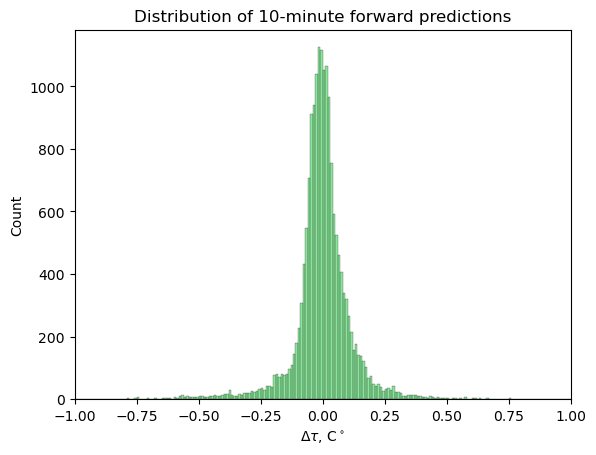

In [110]:
preds_df = pd.DataFrame(np.squeeze(preds) / 10)
# preds_df = pd.DataFrame(np.squeeze(preds) / 10)

sns.histplot(
    data=preds_df,
    stat='count',
    binwidth=0.01,
    binrange=[-1.0, 1.0],
    kde=False,
    palette=sns.color_palette('bright')[2:3],
    legend=False
)

plt.title('Distribution of 10-minute forward predictions')
plt.xlim(-1.0, 1.0)
# plt.ylim(0, 1500)
plt.xlabel('$\Delta \\tau$, C$^\circ$')

plt.savefig(plot_path + 'temp_preds_dist.png', bbox_inches='tight', dpi=200)
plt.show()

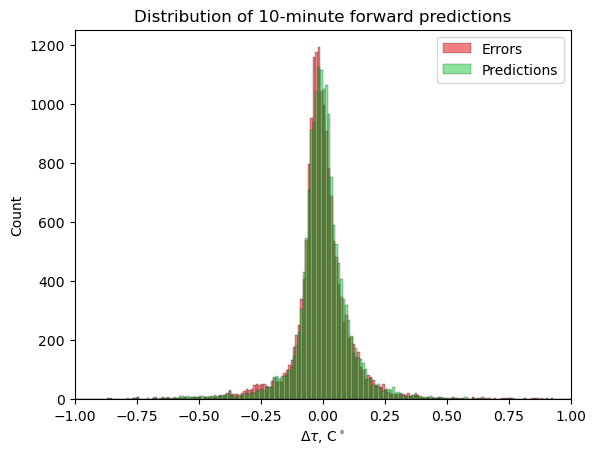

In [111]:
sns.histplot(
    data=diff_df,
    stat='count',
    binwidth=0.01,
    binrange=[-1.0, 1.0],
    kde=False,
    palette=sns.color_palette('bright')[3:4],
    legend=False,
    label='Errors',
    alpha=0.5
)

sns.histplot(
    data=preds_df,
    stat='count',
    binwidth=0.01,
    binrange=[-1.0, 1.0],
    kde=False,
    palette=sns.color_palette('bright')[2:3],
    legend=False,
    label='Predictions'
)

plt.title('Distribution of 10-minute forward predictions')
plt.xlim(-1.0, 1.0)
# plt.ylim(0, 1500)
plt.xlabel('$\Delta \\tau$, C$^\circ$')
plt.legend()

plt.savefig(plot_path + 'temp_both_dist.png', bbox_inches='tight', dpi=200)
plt.show()